In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects


file_path = r"E:\Projects\Gamezone Orders Data\Data\Cleaned\gamezone_orders_data_cleaned.csv"
df = pd.read_csv(
    file_path,
    parse_dates=['purchase_ts_cleaned', 'ship_ts'],
    dtype={
        'purchase_year': 'Int64',
        'purchase_month': 'Int64',
        'time_to_ship': 'Int64',
        'revenue': 'float'
    },
    encoding='utf-8',
    keep_default_na=False,
    na_values=['']  # Only treat empty strings as NaN
)

In [4]:
# 📊 CORRECTED MARKETING KPIs REPORT

# PREPARATION: Add required date columns
df['year_month'] = df['purchase_ts_cleaned'].dt.to_period('M')
df['purchase_year'] = df['purchase_ts_cleaned'].dt.year

# ✅ 1️⃣ CHANNEL PERFORMANCE (Core Metrics)
channel_perf = (
    df.groupby('marketing_channel_cleaned')
    .agg(
        total_revenue=('revenue', 'sum'),
        total_orders=('order_id', 'count'),
        unique_customers=('user_id', 'nunique')
    )
    .reset_index()
)

# Core metrics
channel_perf['aov'] = channel_perf['total_revenue'] / channel_perf['total_orders']
channel_perf['revenue_share_%'] = (
    channel_perf['total_revenue'] / channel_perf['total_revenue'].sum() * 100
)
channel_perf['orders_share_%'] = (
    channel_perf['total_orders'] / channel_perf['total_orders'].sum() * 100
)
channel_perf['revenue_per_customer'] = (
    channel_perf['total_revenue'] / channel_perf['unique_customers']
)
channel_perf['orders_per_customer'] = (
    channel_perf['total_orders'] / channel_perf['unique_customers']
)
channel_perf['revenue_rank'] = channel_perf['total_revenue'].rank(
    ascending=False, method='dense'
).astype(int)
channel_perf['aov_rank'] = channel_perf['aov'].rank(
    ascending=False, method='dense'
).astype(int)

# ✅ 2️⃣ TRUE MONTHLY GROWTH (Chronological)
monthly_channel_chrono = (
    df.groupby(['year_month', 'marketing_channel_cleaned'])
    .agg(
        revenue=('revenue', 'sum'),
        orders=('order_id', 'count'),
        customers=('user_id', 'nunique')
    )
    .reset_index()
    .sort_values(['marketing_channel_cleaned', 'year_month'])
)

# Calculate true month-over-month growth
monthly_channel_chrono['revenue_growth_%'] = (
    monthly_channel_chrono.groupby('marketing_channel_cleaned')['revenue']
    .pct_change() * 100
)
monthly_channel_chrono['orders_growth_%'] = (
    monthly_channel_chrono.groupby('marketing_channel_cleaned')['orders']
    .pct_change() * 100
)

# Average true monthly growth
true_monthly_growth = (
    monthly_channel_chrono.groupby('marketing_channel_cleaned')['revenue_growth_%']
    .mean()
    .reset_index()
    .rename(columns={'revenue_growth_%': 'avg_monthly_growth_%'})
)

# ✅ 3️⃣ COMPOUND MONTHLY GROWTH RATE (CMGR)
def calc_cmgr(group):
    """Calculate Compound Monthly Growth Rate"""
    group = group.sort_values('year_month')
    first = group.iloc[0]['revenue']
    last = group.iloc[-1]['revenue']
    n = len(group) - 1
    if first > 0 and n > 0:
        return ((last / first) ** (1/n) - 1) * 100
    return None

monthly_cmgr = (
    monthly_channel_chrono.groupby('marketing_channel_cleaned')
    .apply(calc_cmgr)
    .reset_index(name='cmgr_%')
)

# ✅ 4️⃣ YEAR-OVER-YEAR GROWTH
monthly_yoy = (
    df.groupby(['purchase_year', 'purchase_month', 'marketing_channel_cleaned'])
    .agg(revenue=('revenue', 'sum'))
    .reset_index()
    .sort_values(['marketing_channel_cleaned', 'purchase_month', 'purchase_year'])
)

# YoY growth for same month across years
monthly_yoy['yoy_growth_%'] = (
    monthly_yoy.groupby(['marketing_channel_cleaned', 'purchase_month'])['revenue']
    .pct_change() * 100
)

# Average YoY growth per channel
avg_yoy_growth = (
    monthly_yoy.groupby('marketing_channel_cleaned')['yoy_growth_%']
    .mean()
    .reset_index()
    .rename(columns={'yoy_growth_%': 'avg_yoy_growth_%'})
)

# ✅ 5️⃣ SEASONAL PATTERN (Corrected - Average First, Then Calculate Change)
monthly_channel_seasonal = (
    df.groupby(['purchase_year', 'purchase_month', 'marketing_channel_cleaned'])
    .agg(revenue=('revenue', 'sum'))
    .reset_index()
)

# Average revenue by calendar month (across all years)
avg_monthly_revenue = (
    monthly_channel_seasonal.groupby(['purchase_month', 'marketing_channel_cleaned'])['revenue']
    .mean()
    .reset_index()
    .sort_values(['marketing_channel_cleaned', 'purchase_month'])
)

# Calculate seasonal change on AVERAGES
avg_monthly_revenue['seasonal_change_%'] = (
    avg_monthly_revenue.groupby('marketing_channel_cleaned')['revenue']
    .pct_change() * 100
)

# Average seasonal pattern
seasonal_pattern = (
    avg_monthly_revenue.groupby('marketing_channel_cleaned')['seasonal_change_%']
    .mean()
    .reset_index()
    .rename(columns={'seasonal_change_%': 'avg_seasonal_change_%'})
)

# ✅ 6️⃣ ACQUISITION INSIGHTS
acquisition_perf = (
    df.groupby('account_creation_method_cleaned')
    .agg(
        revenue=('revenue', 'sum'),
        orders=('order_id', 'count'),
        unique_customers=('user_id', 'nunique')
    )
    .reset_index()
)
acquisition_perf['aov'] = acquisition_perf['revenue'] / acquisition_perf['orders']

# ✅ 7️⃣ GEO-CHANNEL INSIGHTS
geo_channel = (
    df.groupby(['region', 'marketing_channel_cleaned'])
    .agg(
        revenue=('revenue', 'sum'),
        orders=('order_id', 'count')
    )
    .reset_index()
)

geo_channel_pivot = geo_channel.pivot(
    index='region', columns='marketing_channel_cleaned', values='revenue'
).fillna(0)
geo_channel_pivot.columns = [f"revenue_channel_{c}" for c in geo_channel_pivot.columns]
geo_channel_pivot = geo_channel_pivot.reset_index()

# ✅ 8️⃣ CROSS PLATFORM × CHANNEL PERFORMANCE
platform_channel = (
    df.groupby(['purchase_platform', 'marketing_channel_cleaned'])
    .agg(
        revenue=('revenue', 'sum'),
        orders=('order_id', 'count')
    )
    .reset_index()
)
platform_channel['aov'] = platform_channel['revenue'] / platform_channel['orders']

platform_channel_pivot = platform_channel.pivot(
    index='marketing_channel_cleaned',
    columns='purchase_platform',
    values='revenue'
).fillna(0)
platform_channel_pivot.columns = [f"revenue_platform_{c}" for c in platform_channel_pivot.columns]
platform_channel_pivot = platform_channel_pivot.reset_index()

# ✅ 9️⃣ MERGE EVERYTHING INTO FINAL REPORT
marketing_kpis = (
    channel_perf
    .merge(platform_channel_pivot, on='marketing_channel_cleaned', how='left')
    .merge(true_monthly_growth, on='marketing_channel_cleaned', how='left')
    .merge(monthly_cmgr, on='marketing_channel_cleaned', how='left')
    .merge(avg_yoy_growth, on='marketing_channel_cleaned', how='left')
    .merge(seasonal_pattern, on='marketing_channel_cleaned', how='left')
)

# 📊 DISPLAY RESULTS
print("MARKETING CHANNEL PERFORMANCE SUMMARY")
display(marketing_kpis)

print("\nACQUISITION METHOD PERFORMANCE")
display(acquisition_perf)

print("\nGEO × CHANNEL REVENUE BREAKDOWN")
display(geo_channel_pivot)

print("\nPLATFORM × CHANNEL PERFORMANCE")
display(platform_channel)

print("\n📈 GROWTH METRICS EXPLANATION")
print("""
1. avg_monthly_growth_%: True month-over-month growth (Jan 2021 → Feb 2021 → Mar 2021...)
   Shows actual business growth trajectory
   
2. cmgr_%: Compound Monthly Growth Rate
   Smoothed growth rate that compounds from first to last month
   Best metric for understanding sustainable growth
   
3. avg_yoy_growth_%: Year-over-Year growth
   Compares same months across different years (Jan 2021 vs Jan 2022)
   Removes seasonality effects
   
4. avg_seasonal_change_%: Seasonal pattern (your original metric)
   Shows how revenue changes between calendar months
   Example: "Revenue is typically 15% higher in December vs November"
""")

MARKETING CHANNEL PERFORMANCE SUMMARY


C:\Users\shaif\AppData\Local\Temp\ipykernel_18504\2479590153.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calc_cmgr)


,marketing_channel_cleaned,total_revenue,total_orders,unique_customers,aov,revenue_share_%,orders_share_%,revenue_per_customer,orders_per_customer,revenue_rank,aov_rank,revenue_platform_mobile app,revenue_platform_website,avg_monthly_growth_%,cmgr_%,avg_yoy_growth_%,avg_seasonal_change_%
0,affiliate,222428.31,721,648,308.499736,3.615976,3.297658,343.253565,1.112654,3,1,3049.92,219378.39,20.547527,-3.036191,114.172445,13.730341
1,direct,5209858.66,17434,15794,298.833237,84.695707,79.738383,329.863154,1.103837,1,2,43635.81,5166222.85,7.218656,3.520201,147.302610,8.555973
2,email,611182.72,3256,2985,187.709681,9.935884,14.892060,204.751330,1.090787,2,5,97864.24,513318.48,19.917223,7.748709,244.448028,10.832589
3,social media,69526.37,323,304,215.251920,1.130277,1.477314,228.705164,1.062500,4,4,8368.86,61157.51,25.850538,1.416382,172.246541,19.652067
4,unknown,38270.43,130,120,294.387923,0.622155,0.594585,318.920250,1.083333,5,3,1023.24,37247.19,73.032055,17.682586,1611.629153,57.823518



ACQUISITION METHOD PERFORMANCE


,account_creation_method_cleaned,revenue,orders,unique_customers,aov
0,desktop,4778185.51,16458,14900,290.326012
1,mobile,1042855.87,4232,3992,246.421519
2,tablet,69526.37,323,304,215.251920
3,tv,5212.20,25,22,208.488000
4,unknown,255486.54,826,746,309.305738



GEO × CHANNEL REVENUE BREAKDOWN


,region,revenue_channel_affiliate,revenue_channel_direct,revenue_channel_email,revenue_channel_social media,revenue_channel_unknown
0,APAC,4131.28,468554.84,46946.37,5336.70,6256.92
1,EMEA,81939.18,2220714.50,223626.14,24776.65,11519.21
2,LATAM,0.00,76144.58,8782.61,718.67,195.54
3,NA,134062.40,2443282.61,331758.14,38694.35,20298.76
4,unknown,2295.45,1162.13,69.46,0.00,0.00



PLATFORM × CHANNEL PERFORMANCE


,purchase_platform,marketing_channel_cleaned,revenue,orders,aov
0,mobile app,affiliate,3049.92,39,78.203077
1,mobile app,direct,43635.81,651,67.028894
2,mobile app,email,97864.24,1303,75.106861
3,mobile app,social media,8368.86,70,119.555143
4,mobile app,unknown,1023.24,18,56.846667
5,website,affiliate,219378.39,682,321.669194
6,website,direct,5166222.85,16783,307.824754
7,website,email,513318.48,1953,262.835883
8,website,social media,61157.51,253,241.729289
9,website,unknown,37247.19,112,332.564196



📈 GROWTH METRICS EXPLANATION

1. avg_monthly_growth_%: True month-over-month growth (Jan 2021 → Feb 2021 → Mar 2021...)
   Shows actual business growth trajectory
   
2. cmgr_%: Compound Monthly Growth Rate
   Smoothed growth rate that compounds from first to last month
   Best metric for understanding sustainable growth
   
3. avg_yoy_growth_%: Year-over-Year growth
   Compares same months across different years (Jan 2021 vs Jan 2022)
   Removes seasonality effects
   
4. avg_seasonal_change_%: Seasonal pattern (your original metric)
   Shows how revenue changes between calendar months
   Example: "Revenue is typically 15% higher in December vs November"



In [5]:
# Main marketing KPIs summary
marketing_kpis.to_csv('marketing_kpis_summary.csv', index=False)

# Acquisition performance
acquisition_perf.to_csv('acquisition_performance.csv', index=False)

# Geo × Channel breakdown
geo_channel_pivot.to_csv('geo_channel_revenue.csv', index=False)

# Platform × Channel performance
platform_channel.to_csv('platform_channel_performance.csv', index=False)

# Detailed chronological monthly data (for deeper analysis)
monthly_channel_chrono.to_csv('monthly_channel_chronological.csv', index=False)

# Year-over-Year detailed data
monthly_yoy.to_csv('monthly_yoy_growth.csv', index=False)

# Average monthly revenue (for seasonal analysis)
avg_monthly_revenue.to_csv('seasonal_patterns.csv', index=False)

In [6]:
marketing_kpis.head()

,marketing_channel_cleaned,total_revenue,total_orders,unique_customers,aov,revenue_share_%,orders_share_%,revenue_per_customer,orders_per_customer,revenue_rank,aov_rank,revenue_platform_mobile app,revenue_platform_website,avg_monthly_growth_%,cmgr_%,avg_yoy_growth_%,avg_seasonal_change_%
0,affiliate,222428.31,721,648,308.499736,3.615976,3.297658,343.253565,1.112654,3,1,3049.92,219378.39,20.547527,-3.036191,114.172445,13.730341
1,direct,5209858.66,17434,15794,298.833237,84.695707,79.738383,329.863154,1.103837,1,2,43635.81,5166222.85,7.218656,3.520201,147.302610,8.555973
2,email,611182.72,3256,2985,187.709681,9.935884,14.892060,204.751330,1.090787,2,5,97864.24,513318.48,19.917223,7.748709,244.448028,10.832589
3,social media,69526.37,323,304,215.251920,1.130277,1.477314,228.705164,1.062500,4,4,8368.86,61157.51,25.850538,1.416382,172.246541,19.652067
4,unknown,38270.43,130,120,294.387923,0.622155,0.594585,318.920250,1.083333,5,3,1023.24,37247.19,73.032055,17.682586,1611.629153,57.823518


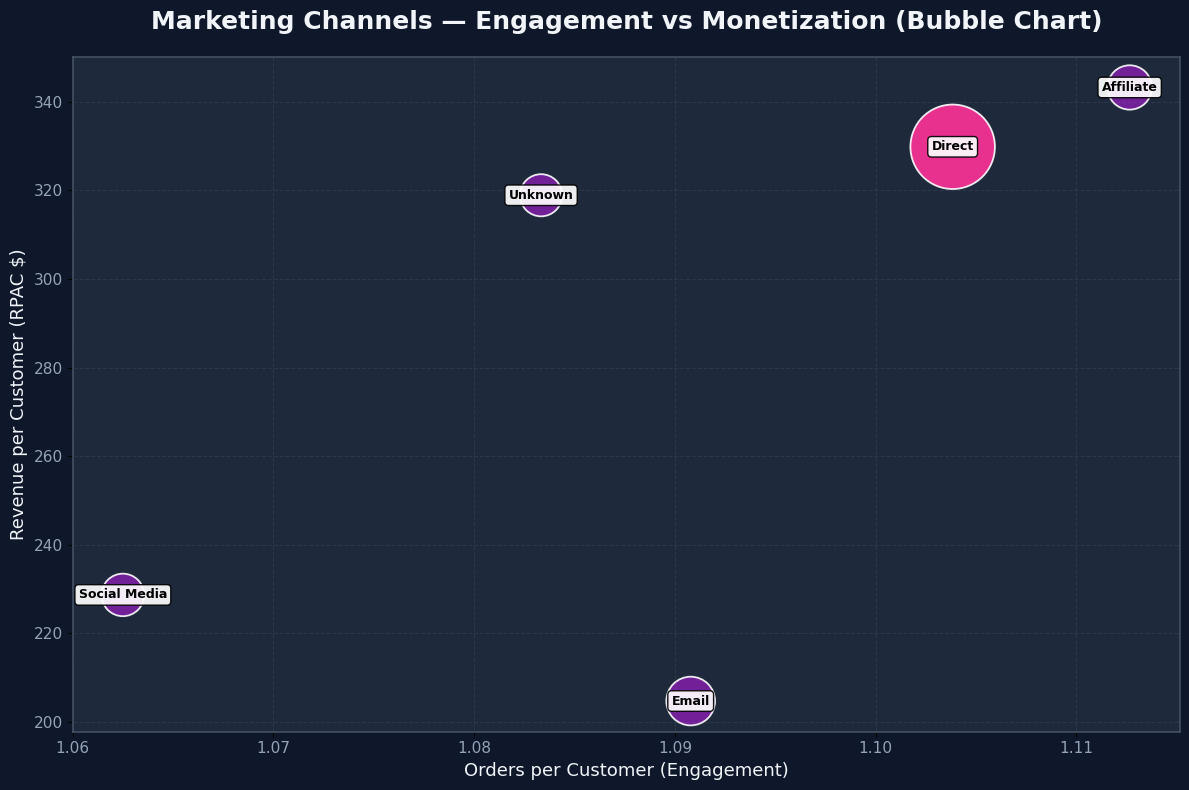

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# Use marketing_kpis ONLY
# -----------------------------------------
mk = marketing_kpis.copy()   # safe alias, df untouched

# -----------------------------------------
# COLOR GRADIENT (revenue share)
# -----------------------------------------
gradient_colors = ["#7B1FA2", "#03b2ed", "#FF3399"]

share_col = "revenue_share_%"

norm = (mk[share_col] - mk[share_col].min()) / (mk[share_col].max() - mk[share_col].min())

color_vals = [
    gradient_colors[int(n * (len(gradient_colors) - 1))]
    for n in norm
]

# -----------------------------------------
# BUBBLE SIZE based on revenue
# -----------------------------------------
sizes = (mk["total_revenue"] / mk["total_revenue"].max()) * 2800 + 900

# -----------------------------------------
# FIGURE — DARK THEME
# -----------------------------------------
plt.figure(figsize=(12, 8))
fig = plt.gcf()
fig.patch.set_facecolor("#0f172a")   # very dark slate

ax = plt.gca()
ax.set_facecolor("#1e293b")          # slate panel

# -----------------------------------------
# BUBBLE CHART
# X = orders_per_customer (engagement)
# Y = revenue_per_customer (RPAC)
# -----------------------------------------
plt.scatter(
    mk["orders_per_customer"],
    mk["revenue_per_customer"],
    s=sizes,
    c=color_vals,
    alpha=0.9,
    edgecolor="white",
    linewidth=1.3
)

# -----------------------------------------
# TITLES & LABELS
# -----------------------------------------
plt.title(
    "Marketing Channels — Engagement vs Monetization (Bubble Chart)",
    fontsize=18,
    fontweight="bold",
    color="#f1f5f9",
    pad=20
)

plt.xlabel("Orders per Customer (Engagement)", fontsize=13, color="#f1f5f9")
plt.ylabel("Revenue per Customer (RPAC $)", fontsize=13, color="#f1f5f9")

plt.xticks(color="#94a3b8", fontsize=11)
plt.yticks(color="#94a3b8", fontsize=11)

# -----------------------------------------
# AXIS SPINES
# -----------------------------------------
for spine in ax.spines.values():
    spine.set_color("#475569")
    spine.set_linewidth(1.1)

plt.grid(alpha=0.12, linestyle="--", color="#94a3b8")

# -----------------------------------------
# LABELS — white box with black text
# -----------------------------------------
for i, row in mk.iterrows():
    plt.text(
        row["orders_per_customer"],
        row["revenue_per_customer"],
        row["marketing_channel_cleaned"].title(),
        fontsize=9,
        fontweight="bold",
        color="black",
        ha="center",
        va="center",
        bbox=dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round,pad=0.30",
            alpha=0.92
        )
    )

plt.tight_layout()
plt.show()
